# Build Binary Classification Model
## Block 1: Data Loading and Exploration
Load the iris dataset and explore its characteristics

In [1]:
from src.data_preprocessing import DataLoader, get_dataset_info

loader = DataLoader()
df = loader.load_sklearn_dataset("iris", save_raw=True)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:\n{df.head()}")

# Get comprehensive dataset information
info = get_dataset_info(df)
print("\nDataset Information:")
print(f"  - Numeric columns: {info['numeric_columns']}")
print(f"  - Missing values: {sum(info['missing_values'].values())}")
print(f"  - Duplicates: {info['duplicates']}")

Dataset saved to data\raw\iris.csv
Dataset shape: (150, 5)

First few rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  

Dataset Information:
  - Numeric columns: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']
  - Missing values: 0
  - Duplicates: 1


## Block 2: Data Preprocessing
Preprocess the data: handle missing values, encode categorical variables, scale features

In [3]:

import pandas as pd
from src.data_preprocessing import create_pipeline

X_train, X_test, y_train, y_test, preprocessor = create_pipeline(
    df,
    target_column="target",
    handle_missing=True,
    missing_strategy="mean",
    encode_categorical=True,
    scale_features=True,
    scaling_method="standard",
    remove_outliers=False,
    test_size=0.2,
    random_state=42,
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(pd.Series(y_train).value_counts().sort_index())

Training set shape: (120, 4)
Test set shape: (30, 4)

Class distribution in training set:
target
0    40
1    40
2    40
Name: count, dtype: int64


## Block 3: Feature Engineering
Create and select important features to improve model performance

In [4]:
from src.feature_engineering import FeatureCreator, FeatureSelector
import pandas as pd

# Create additional features
creator = FeatureCreator()
# Note: For binary classification with this dataset, feature engineering may be optional
# Add polynomial features if needed
# X_train_df = pd.DataFrame(X_train)
# X_train_engineered = creator.create_polynomial_features(X_train_df, degree=2)

# Select most important features using SelectKBest
selector = FeatureSelector()
X_train_selected, selected_features = selector.select_k_best(
    X_train, y_train, k=min(10, X_train.shape[1])
)
X_test_selected = X_test[:, [list(range(X_train.shape[1])).index(i) for i in range(len(selected_features)) if i < X_train.shape[1]]]

print(f"Selected features: {selected_features}")
print(f"Features after selection - Train shape: {X_train_selected.shape}, Test shape: {X_test_selected.shape}")

Selected features: ['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3']
Features after selection - Train shape: (120, 4), Test shape: (30, 4)


### Block 4: Model Training
Train multiple binary classification models and compare their performance

In [5]:
from src.models import BinaryClassifier, ModelTrainer

trainer = ModelTrainer(random_state=42)

model_configs = {
    "Random Forest": {"model_type": "random_forest", "n_estimators": 100},
    "Logistic Regression": {"model_type": "logistic_regression", "max_iter": 1000},
    "SVM": {"model_type": "svm", "kernel": "rbf"},
    "Gradient Boosting": {"model_type": "gradient_boosting", "n_estimators": 100},
}

trained_models = trainer.train_multiple_models(X_train, y_train, model_configs)

print(f"\nSuccessfully trained {len(trained_models)} models:")
for model_name in trained_models.keys():
    print(f"  ✓ {model_name}")

Training Random Forest...
Training Logistic Regression...
Training SVM...
Training Gradient Boosting...

Successfully trained 4 models:
  ✓ Random Forest
  ✓ Logistic Regression
  ✓ SVM
  ✓ Gradient Boosting


## Block 5: Model Evaluation
Evaluate and compare all trained models using comprehensive metrics

In [6]:
from src.evaluation import ClassificationEvaluator, compare_models, print_evaluation_summary

# Compare models on test set
comparison_results = compare_models(trained_models, X_test, y_test)
print("\nModel Comparison Results:")
print(comparison_results)

# Detailed evaluation of best model
best_model_name = comparison_results.index[0]
best_model = trained_models[best_model_name]

print(f"\n{'='*60}")
print(f"Detailed Evaluation: {best_model_name}")
print(f"{'='*60}")

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else None

print_evaluation_summary(y_test, y_pred, y_pred_proba, best_model_name)


Model Comparison Results:
                     accuracy  precision    recall  f1_score  \
Gradient Boosting    0.966667   0.969697  0.966667  0.966583   
SVM                  0.966667   0.969697  0.966667  0.966583   
Logistic Regression  0.933333   0.933333  0.933333  0.933333   
Random Forest        0.900000   0.902357  0.900000  0.899749   

                     matthews_corrcoef  cohen_kappa   roc_auc  log_loss  
Gradient Boosting             0.951587         0.95  0.996667  0.174449  
SVM                           0.951587         0.95  0.996667  0.112532  
Logistic Regression           0.900000         0.90  0.996667  0.173973  
Random Forest                 0.851420         0.85  0.993333  0.120382  

Detailed Evaluation: Gradient Boosting

Evaluation Summary: Gradient Boosting

Overall Metrics:
----------------------------------------
  accuracy            : 0.9667
  precision           : 0.9697
  recall              : 0.9667
  f1_score            : 0.9666
  matthews_corrcoef 

#### Block 6: Visualization and Results
Visualize model performance with confusion matrix and ROC curve

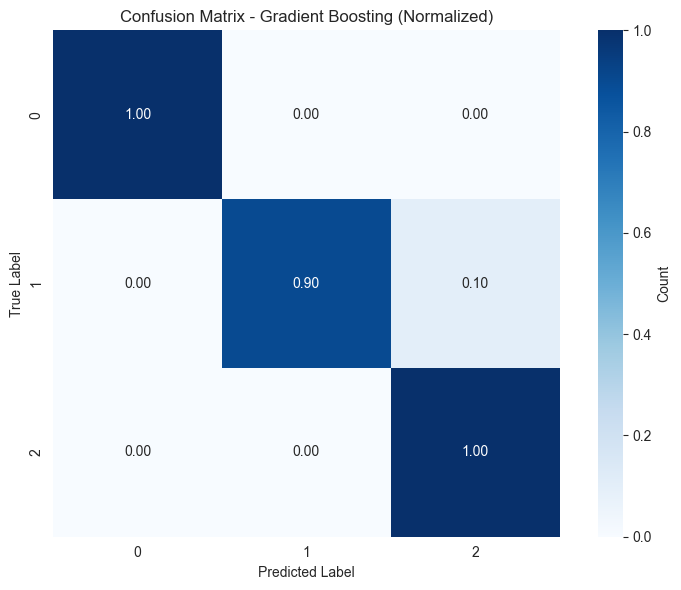

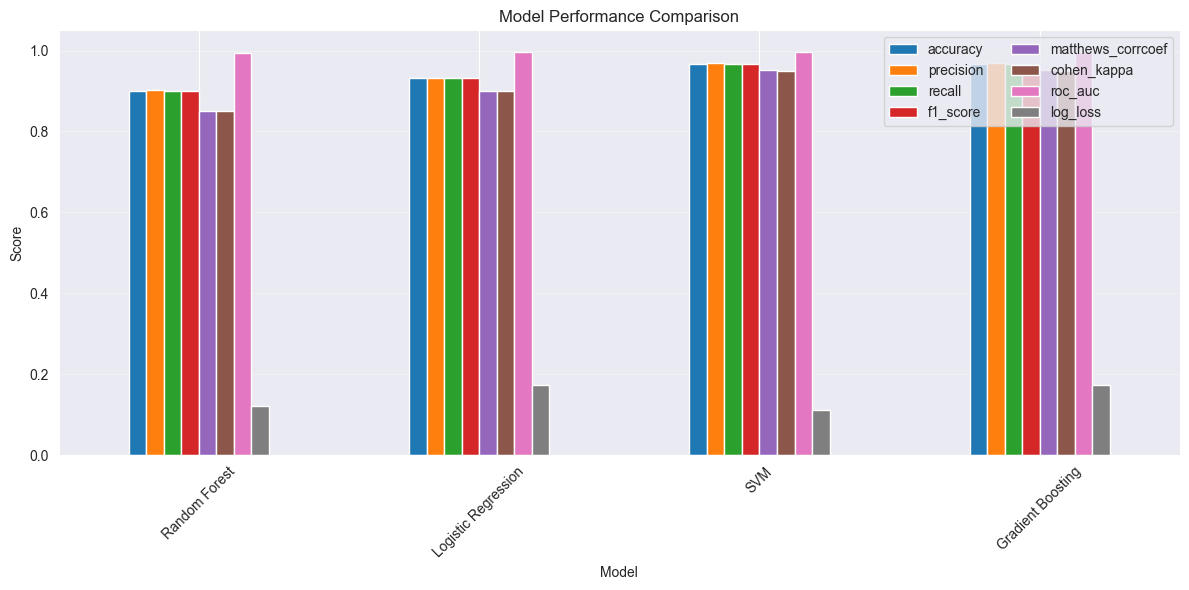


✓ Binary classification pipeline completed successfully!


In [7]:
from src.evaluation import ClassificationEvaluator
import matplotlib.pyplot as plt

evaluator = ClassificationEvaluator(model_name=best_model_name)

# Plot confusion matrix
fig_cm = evaluator.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

# Plot ROC curve (if probabilities available)
if y_pred_proba is not None and len(set(y_test)) == 2:
    fig_roc = evaluator.plot_roc_curve(y_test, y_pred_proba)
    plt.show()

# Plot metrics comparison across all models
fig_metrics = evaluator.plot_metrics_comparison(
    {name: compare_models({name: model}, X_test, y_test).to_dict('index')[name]
     for name, model in trained_models.items()}
)
plt.show()

print("\n✓ Binary classification pipeline completed successfully!")